# 0.0 Imports

### 0.1. Helper functions

In [3]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 0.2 Loading data

In [4]:
#df_sales_raw = pd.read_csv(r'C:\Users\laais\OneDrive\Área de Trabalho\Programação\Curso Ds em Produção\rossmann-store-sales\train.csv', low_memory=False)

#df_store_raw = pd.read_csv(r'C:\Users\laais\OneDrive\Área de Trabalho\Programação\Curso Ds em Produção\rossmann-store-sales\store.csv', low_memory=False)

In [5]:
df_sales_raw = pd.read_csv(r'C:\Users\laism\Downloads\rossmann-store-sales\train.csv', low_memory=False)

df_store_raw = pd.read_csv(r'C:\Users\laism\Downloads\rossmann-store-sales\store.csv', low_memory=False)

In [6]:
#merge dos dois dfs
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 Descrição dos dados

In [7]:
#copia dos dados originais para ficar tipo como um backup
df1 = df_raw.copy()

### 1.1. Rename columns

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

#função que deixa tudo minusculo e separado por _
snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

### 1.2. Data dimensions

In [10]:
print('N° de linhas: {}'.format(df1.shape[0]))
print('N° de colunas {}'.format(df1.shape[1]))

N° de linhas: 1017209
N° de colunas 18


### 1.3. Data types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [13]:
#quantidade de células vazias
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Preenchendo o NA

In [14]:
#CompetitionDistance - distance in meters to the nearest competitor store
#vou assumir que se o valor é mt maior que a distância máxima que tem um competidor proximo então é a msm coisa que dizer que não tem um competidor proxim

max_value = df1['competition_distance'].max()
#isnan avalia se é NA
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

In [15]:
#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
#vou assumir que é vazio pqe não tem um competidor mais proximo ou tem um competidor proximo mas não temos info de quando abriu
#vou substituir pelo mês da data da venda

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [16]:
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
#vou substituir pela data da venda

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [17]:
#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
#dict para trocar o num pelo nome do mês
month_map = {1: 'Jan',
             2: 'Fev',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sept',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

#susbtitui o N/A por zero
df1['promo_interval'].fillna(0, inplace=True)

#extraindo o mês da data e aplicando o dicionario para fazer a tradução
df1['month_map'] = df1['date'].dt.month.map(month_map)

#avaliação se o month_map está dentro do intervalo para ver se a loja está na promoção (1) ou não (0)
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [18]:
#quantidade de células vazias
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Change Types

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
#passando para inteiro
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Estatísticas descritivas

- Métricas de tendência central: média e mediana
- Métricas de dispersão: desvio padrão, max, min e range, skew e kurtosis

In [21]:
#separando os atributos numéricos
num_attributes = df1.select_dtypes( include = ['int64','float64'])

#separando os atributos categóricos
cat_attributes = df1.select_dtypes( exclude = ['int64','int32','float64','datetime64[ns]'])

### 1.7.1 Atributos numéricos

In [22]:
#media e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#desvio padrão, max, min e range, skew e kurtosis
std = pd.DataFrame(num_attributes.apply( np.std )).T
min_ = pd.DataFrame(num_attributes.apply( min )).T
max_ = pd.DataFrame(num_attributes.apply( max )).T
range_ = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
skew = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
kurtosis = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenando
m = pd.concat([min_, max_, range_, ct1, ct2, std, skew, kurtosis]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.161100,0.0,0.367623,1.843742,1.399388


C:\Users\laism\AppData\Local\Temp\ipykernel_26432\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

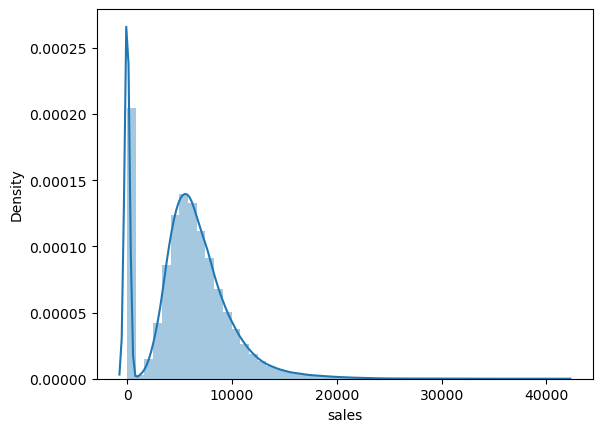

In [23]:
sns.distplot(df1['sales'])

C:\Users\laism\AppData\Local\Temp\ipykernel_26432\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

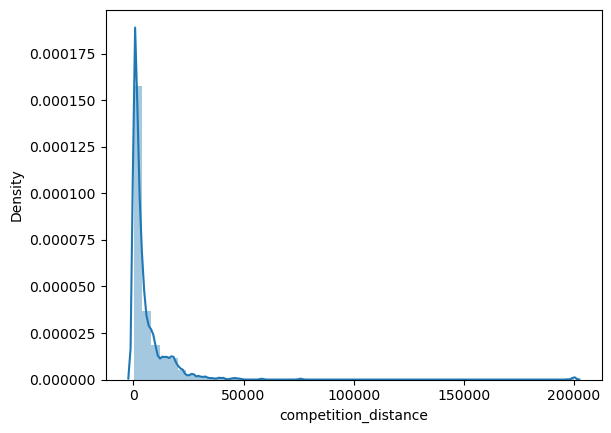

In [24]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Atributos categóricos

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

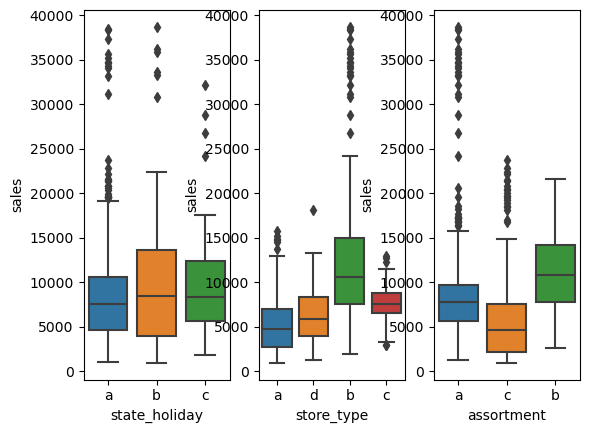

In [26]:
#filtrando os dias não tem feriado e que tem venda maior q 0
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)        